In [1]:
import pickle
# 导入向量化后的数据集
np_vectorized_tfidf = pickle.load(open('model/vectorized_generated_corpus_tfidf.pkl', 'rb'))

In [2]:
# 读入正确标签（Labels）
labels = []
# 读入数据集
with open('sixTypes-GeneratedLabels.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        labels.append(line.strip('\n'))

In [8]:
# 利用 RandomizedSearchCV 搜索不同的 维度 和 gamma 值来找到最优解（利用 V-measure 评估）

# Import required libraries
from sklearn.model_selection import RandomizedSearchCV
from sklearn.manifold import Isomap
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import v_measure_score

# Define the parameter values that want to search
param_grid = {
    'isomap__n_components': range(2, 10),
    'isomap__n_neighbors': range(1, 51),
    'kmeans__n_clusters': range(6, 7)
}

# Define a scoring function that takes in y_true and y_pred as arguments and returns the v_measure_score
def v_measure_scorer(estimator, X, y_true):
    y_pred = estimator.predict(X)
    return v_measure_score(y_true, y_pred)

# Create a randomize search object
isomap = Isomap()
kmeans = KMeans()
model = Pipeline([('isomap', isomap), ('kmeans', kmeans)])
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=5, random_state=9, scoring=v_measure_scorer, verbose=3)

# Fit the random search object to the data
random_search.fit(np_vectorized_tfidf, labels)

# Get the best estimator
best_estimator = random_search.best_estimator_
print('best_estimator', best_estimator)

# Use the best estimator to make predictions
y_pred = best_estimator.predict(np_vectorized_tfidf)

# Use V-measure to evaluate the clustering results
score = v_measure_score(labels, y_pred)
print('V-measure:', score)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END isomap__n_components=3, isomap__n_neighbors=8, kmeans__n_clusters=6;, score=0.453 total time=   0.4s
[CV 2/5] END isomap__n_components=3, isomap__n_neighbors=8, kmeans__n_clusters=6;, score=0.448 total time=   0.5s
[CV 3/5] END isomap__n_components=3, isomap__n_neighbors=8, kmeans__n_clusters=6;, score=0.434 total time=   0.5s
[CV 4/5] END isomap__n_components=3, isomap__n_neighbors=8, kmeans__n_clusters=6;, score=0.073 total time=   0.4s
[CV 5/5] END isomap__n_components=3, isomap__n_neighbors=8, kmeans__n_clusters=6;, score=0.291 total time=   0.4s
[CV 1/5] END isomap__n_components=2, isomap__n_neighbors=33, kmeans__n_clusters=6;, score=0.224 total time=   0.6s
[CV 2/5] END isomap__n_components=2, isomap__n_neighbors=33, kmeans__n_clusters=6;, score=0.409 total time=   0.6s
[CV 3/5] END isomap__n_components=2, isomap__n_neighbors=33, kmeans__n_clusters=6;, score=0.018 total time=   0.6s
[CV 4/5] END isomap__n_c

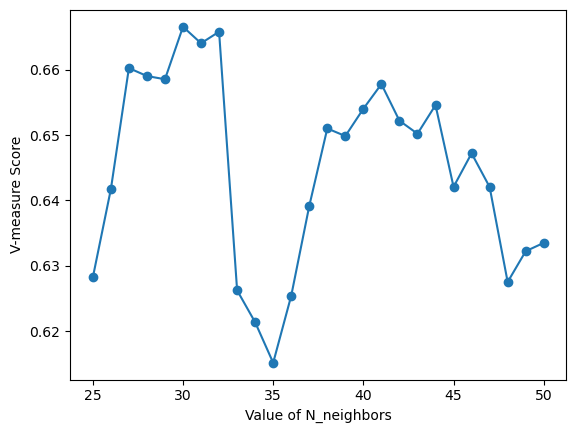

In [4]:
# 遍历 gamma 值找到最优解（利用 V-measure 评估）
v_measure_score_list = []

import matplotlib.pyplot as plt
from sklearn.manifold import Isomap
from sklearn.cluster import KMeans
from sklearn import metrics
for n_neighbor in range(25, 51):
    # 画散点图之前，首先用 Isomap 降维
    isomap = Isomap(n_components=2, n_neighbors=n_neighbor)
    decomposition_data = isomap.fit_transform(np_vectorized_tfidf)
    # 选用 k 值做 K-means 算法聚类
    y_pred = KMeans(n_clusters=6, init='k-means++', random_state=9).fit_predict(decomposition_data)
    # 利用 V-measure 评估当前 K-Means 聚类效果（利用 TFIDF 表征）
    v_measure_score_list.append(metrics.v_measure_score(labels, y_pred))

# 画图
plt.plot(range(25, 51), v_measure_score_list, marker='o')
plt.xlabel('Value of N_neighbors')
plt.ylabel('V-measure Score')
plt.show()

In [5]:
from sklearn.manifold import Isomap
# 画散点图之前，首先用 Isomap 降维，不输入 n_neighbors 时默认为 5
isomap = Isomap(n_components=2, n_neighbors=30)
decomposition_data = isomap.fit_transform(np_vectorized_tfidf)

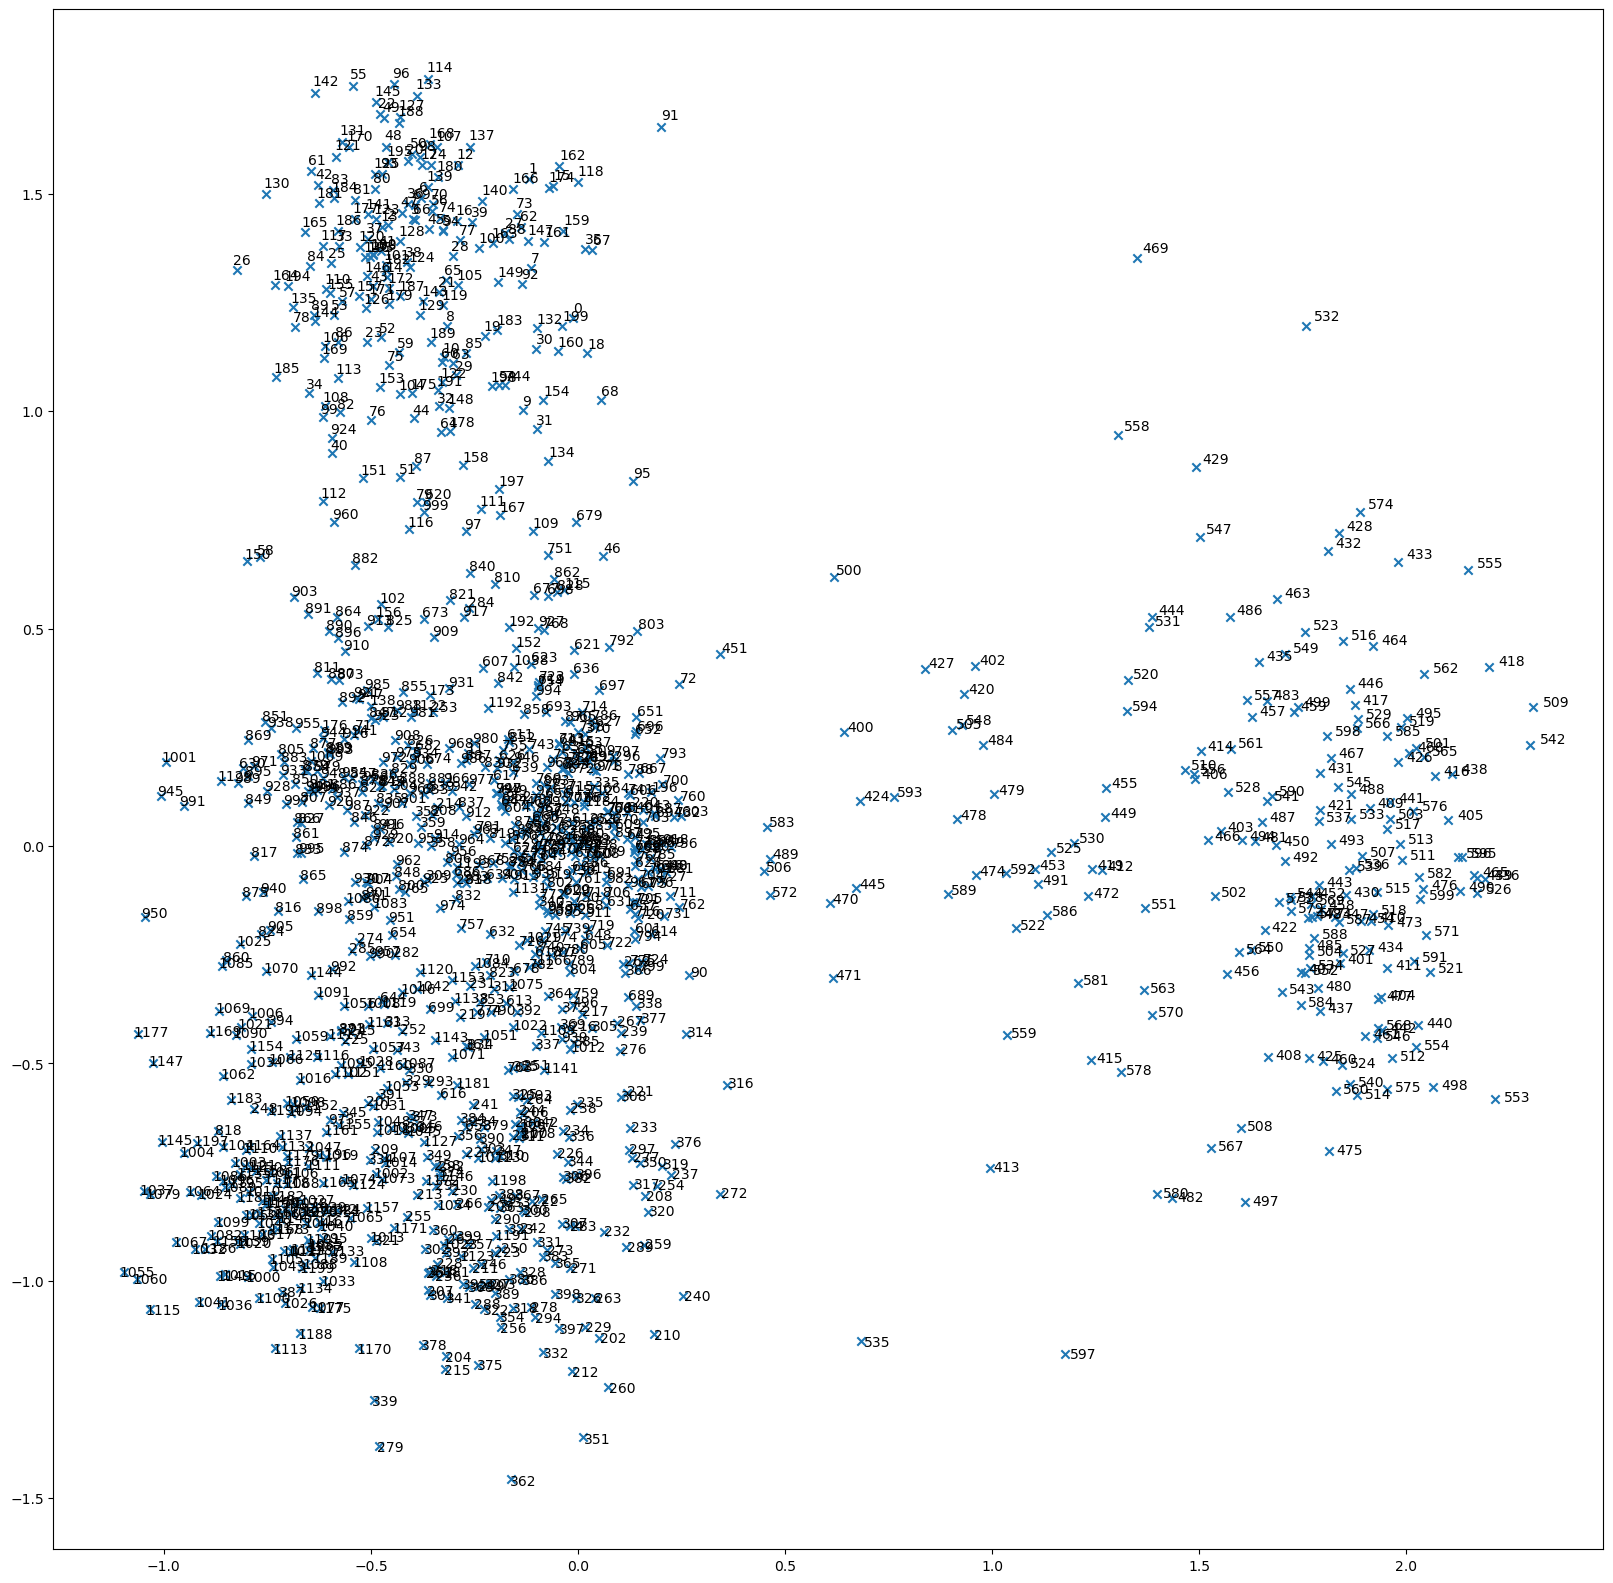

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 20))
ax = plt.axes()
plt.scatter(decomposition_data[:, 0], decomposition_data[:, 1], marker='x')
for i in range(len(decomposition_data)):
    plt.text(decomposition_data[:, 0][i] * 1.01, decomposition_data[:, 1][i] * 1.01, i, fontsize=10)
plt.show()

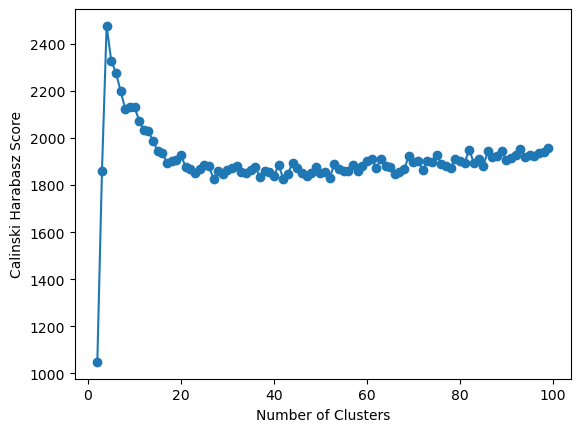

In [7]:
# K-means 算法聚类并利用 Calinski Harabasz Score 评估效果
from sklearn.cluster import KMeans
from sklearn import metrics
calinski_harabasz_score_list = []
for n_cluster in range(2, 100):
    y_pred = KMeans(n_clusters=n_cluster, init='k-means++', random_state=9).fit_predict(decomposition_data)
    current_score = metrics.calinski_harabasz_score(decomposition_data, y_pred)
    calinski_harabasz_score_list.append(current_score)

plt.plot(range(2,100), calinski_harabasz_score_list, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski Harabasz Score')
plt.show()

In [8]:
calinski_harabasz_score_list.index(max(calinski_harabasz_score_list))

2

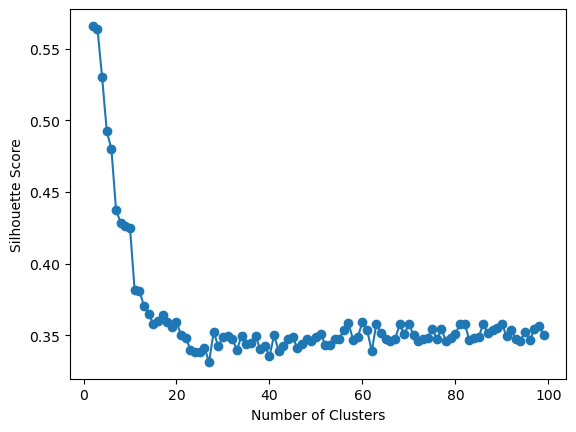

In [9]:
# K-means 算法聚类并利用 Silhouette Score（轮廓系数）评估效果
silhouette_score_list = []
for n_cluster in range(2, 100):
    km = KMeans(n_clusters=n_cluster, random_state=9)
    y_pred = km.fit_predict(decomposition_data)
    current_score = metrics.silhouette_score(decomposition_data, km.labels_ , metric='euclidean')
    silhouette_score_list.append(current_score)

plt.plot(range(2,100), silhouette_score_list, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [10]:
silhouette_score_list.index(max(silhouette_score_list))

0

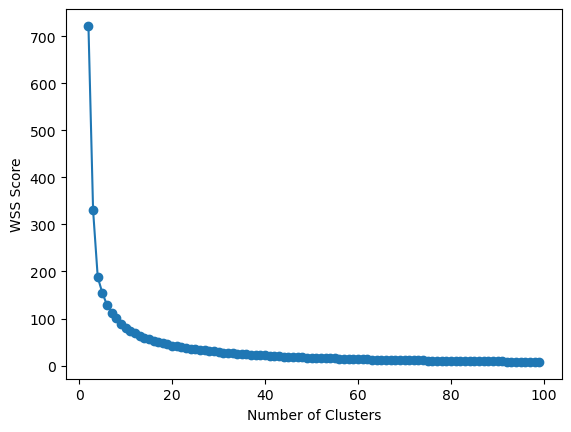

In [11]:
# K-means 算法聚类并利用 WSS（Within-cluster Sum of Squares）评估效果
WSS_score_list = []
for n_cluster in range(2, 100):
    km = KMeans(n_clusters=n_cluster, random_state=9)
    y_pred = km.fit_predict(decomposition_data)
    current_score = km.inertia_
    WSS_score_list.append(current_score)

plt.plot(range(2,100), WSS_score_list, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WSS Score')
plt.show()

In [12]:
# 选用 k 值做 K-means 算法聚类
y_pred = KMeans(n_clusters=6, init='k-means++', random_state=9).fit_predict(decomposition_data)

In [13]:
print(y_pred[:10])

[4 4 4 4 0 4 4 4 4 4]


In [14]:
import numpy as np
# 用 dict 统计出所有类别的坐标
y_pred_dict = {}
for i in range(len(decomposition_data)):
    if y_pred[i] not in y_pred_dict:
        y_pred_dict[y_pred[i]] = decomposition_data[i].reshape(1, 2)
    else:
        y_pred_dict[y_pred[i]] = np.vstack((y_pred_dict[y_pred[i]], decomposition_data[i]))

In [15]:
for key, value in y_pred_dict.items():
    print(key, value[:, 0].mean())

4 -0.38113225715960136
0 -0.14459961253570283
1 -0.5211312562820164
5 0.013273914146923976
3 -0.6873156844032122
2 1.7041689971004839


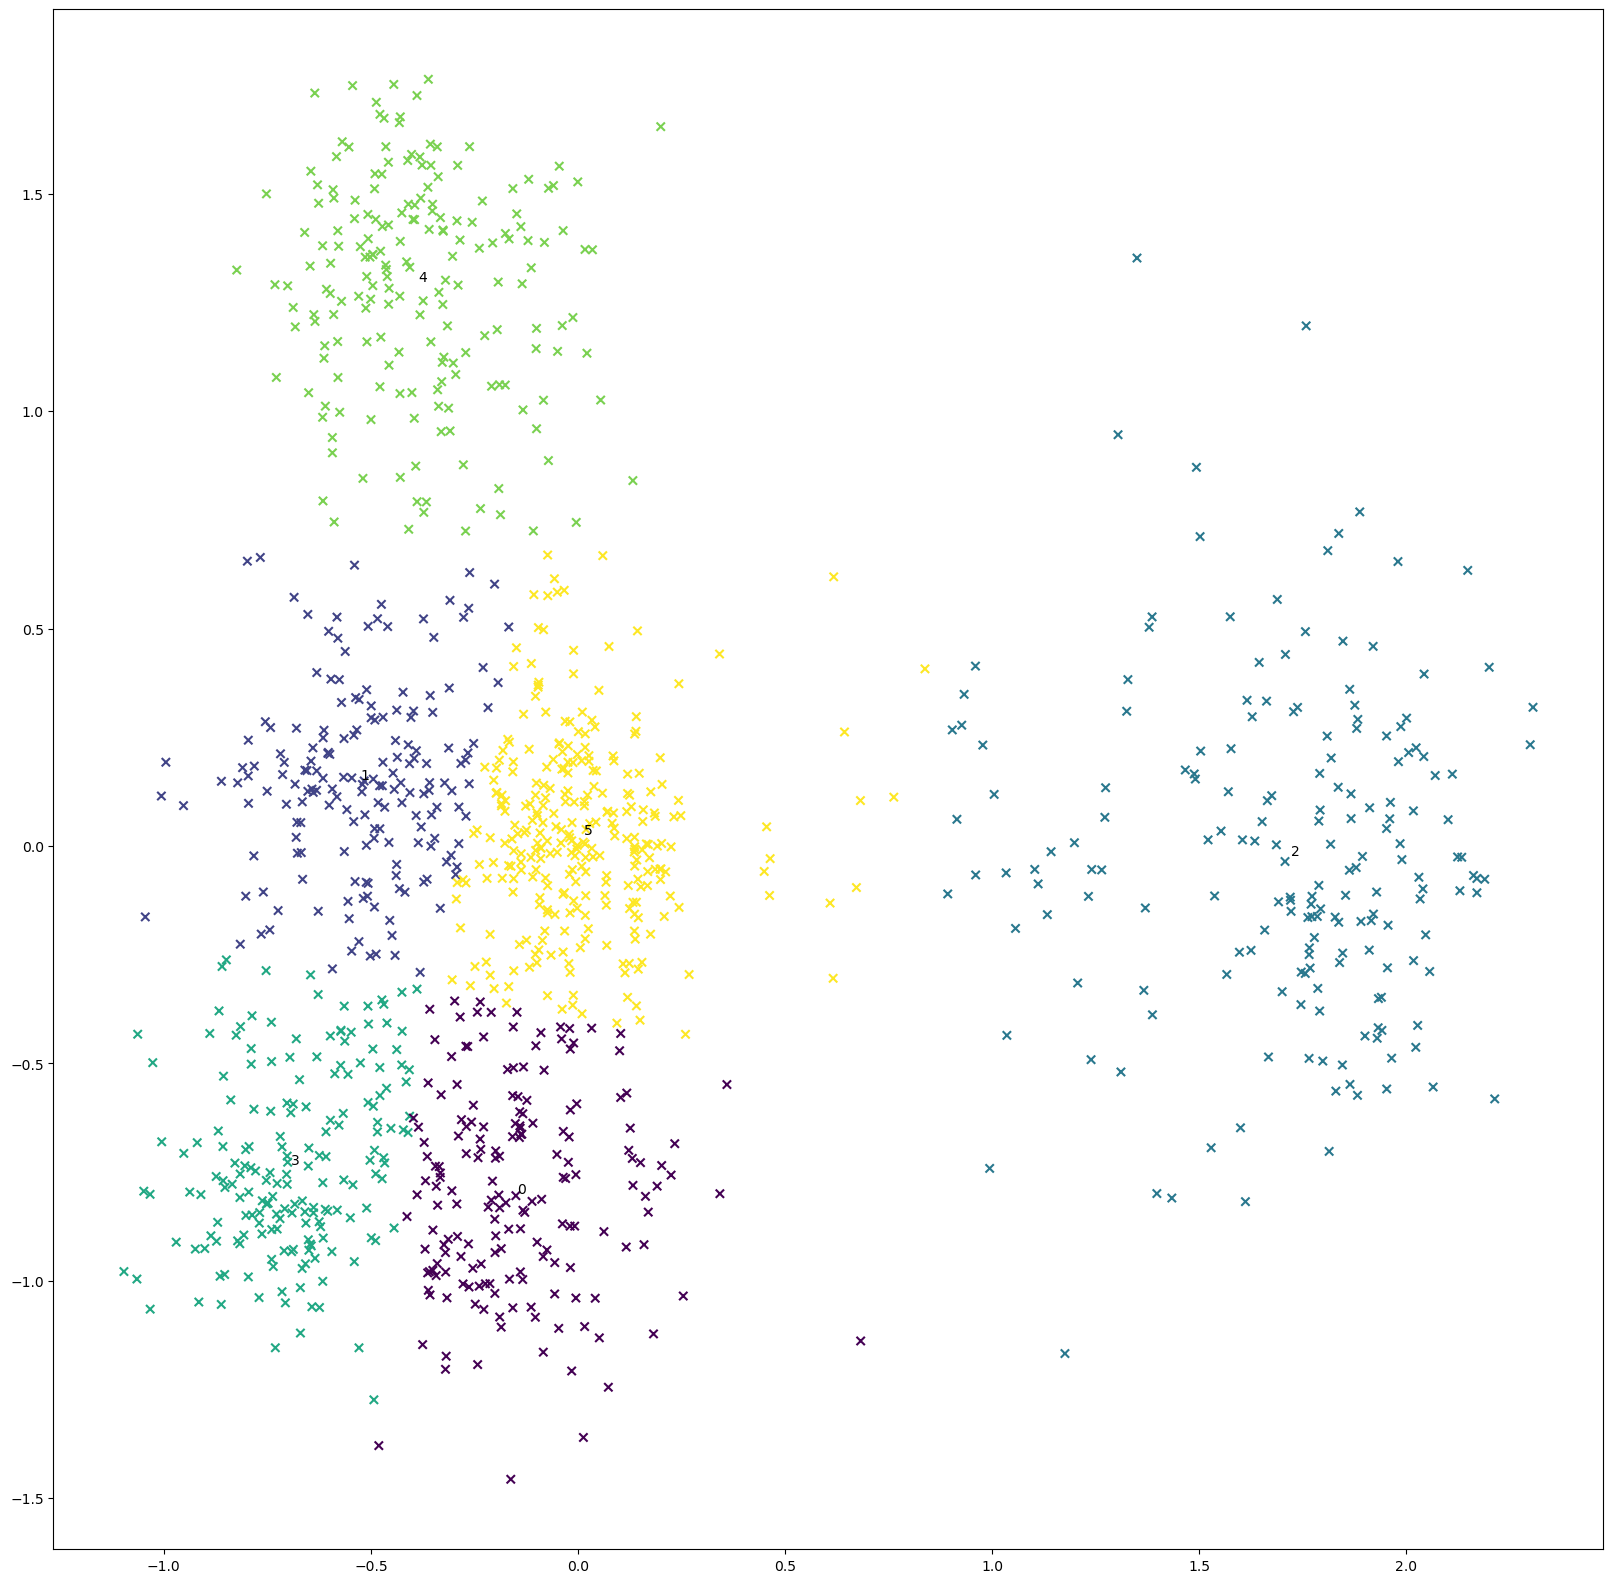

In [16]:
fig = plt.figure(figsize=(20, 20))
ax = plt.axes()
plt.scatter(decomposition_data[:, 0], decomposition_data[:, 1], c=y_pred, marker='x')
for key, value in y_pred_dict.items():
    plt.text(value[:, 0].mean() * 1.01, value[:, 1].mean() * 1.01, key, fontsize=10)
plt.show()

In [17]:
# 利用 Calinski Harabasz Score 评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.calinski_harabasz_score(decomposition_data, y_pred)

2277.544606152803

In [18]:
# 利用 Silhouette Score（轮廓系数）评估当前 K-Means 聚类效果（利用 TFIDF 表征）
km = KMeans(n_clusters=6, random_state=9)
y_pred = km.fit_predict(decomposition_data)
metrics.silhouette_score(decomposition_data, km.labels_, metric='euclidean')

0.480037685733935

In [19]:
# 读入正确标签（Labels）
labels = []
# 读入数据集
with open('sixTypes-GeneratedLabels.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        labels.append(line.strip('\n'))

In [20]:
labels[:10]

['CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP']

In [21]:
# 利用 Homogeneity 评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.homogeneity_score(labels, y_pred)

0.6633506480534581

In [22]:
# 利用 Completeness 评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.completeness_score(labels, y_pred)

0.6698297981081995

In [23]:
# 利用 V-measure 评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.v_measure_score(labels, y_pred)

0.6665744790059915

In [24]:
# 利用 Adjusted Rand Index（调整兰德系数）评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.adjusted_rand_score(labels, y_pred)

0.6292235635295661

In [25]:
# 利用 Adjusted Mutual Information Score（调整互信息）评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.adjusted_mutual_info_score(labels, y_pred)

0.664601033852291

In [26]:
# 利用 Fowlkes-Mallows scores 评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.fowlkes_mallows_score(labels, y_pred)

0.692044337042304